# Warm-Koud Model

Implementatie van de single node linear classifier van Koen: Vind een neuraal netwerk dat warm (T>22) kan onderscheiden van koud, ie vind een approximatie van
$$\Theta(T-22)$$
in de vormen
$$\sigma(W_1\,(T+W_2))$$
en 
$$\sigma(a\, T+b)\,.$$
In het eerste scenario willen we duidelijk de parameterwaarden
$$W_1=\inf\,,\quad W_2=-22$$
terwijl het 2e scenario allicht slechter convergeert naar afhankelijke parameters, beiden oneindig
$$a=\inf\,,\quad b = -22\, a$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N=200000
Ts= np.random.normal(22,4,N)
alpha = 0.01

In [3]:
def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def nz(T):
    return T / 40

def exact(T):
    return (np.sign(T-22) + 1) / 2

## 1-layer benadering

De naive benadering is het gebruik van een enkel perceptron met een weight, een bias en een sigmoid. 

De gradient van de benadering $App$ van $Ex$ ligt dan langs 
$$ {\delta a\choose \delta b}\sim\frac{1}{2}{\partial_{a}\choose\partial_b}[App(T)-Ex(T)]^2= [App(T)-Ex(T)](\partial\sigma){T\choose 1}$$
en de evenredigheidsfactor noemen we $-\alpha$. We normaliseren nog het argument $T$ om een redelijke slope van de $\sigma$ te vinden.

In [4]:
def Approx1(T,A,B):
    return sigmoid( nz(T) * A + B )

def deltaA(T,A,B):
    global alpha
    app1 = Approx1(T,A,B)
    error = app1-exact(T)
    der = app1 * ( 1 - app1 )
    return - alpha * error * der * nz(T)

def deltaB(T,A,B):
    global alpha
    app1 = Approx1(T,A,B)
    error = app1 - exact(T)
    der = app1 * ( 1 - app1 )
    return - alpha * error * der

We loop-en de updates over onze $N$ normaal verdeelde datapunten en vinden divergerende parameters (zoals verwacht) en een redelijke benadering voor de kritische temperatuur in het quotient.

In [5]:
A=1
B=-0.2
As=[]
Bs=[]
for T in Ts:
    A=A+deltaA(T,A,B)
    B=B+deltaB(T,A,B)
    As+=[A]
    Bs+=[B]
As=np.array(As)
Bs=np.array(Bs)

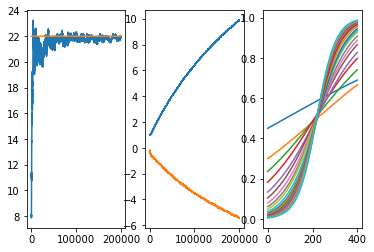

In [6]:
fig1,ax1=plt.subplots(1,3)
ax1[1].plot(As)
ax1[1].plot(Bs)
ax1[0].plot(-40*Bs / As)
ax1[0].plot(22*np.ones((N,)))
ax1[2].plot(Approx1(np.expand_dims(np.arange(400)/10,axis=1),np.expand_dims(As[::N//20],axis=0),np.expand_dims(Bs[::N//20],axis=0)))
plt.show()

In [7]:
test = np.random.randint(0,44,20*N)
success1 = np.abs(Approx1(test,A,B)-exact(test))<0.4
np.mean(success1)

0.95474099999999995

## 2-layer approach

We kunnen exact hetzelfde doen maar met 2-layers en een product vanparameters in onze definitie, om het quotient in de benadering vna de temperatuur kwijt te spelen. We kunnen dan ook kijken of de gradient descent efficienter is. Dat zou je kunnen verwachten omdat nu een van de parameters naar een eindige waarde moet convergeren.

De variatie-functies zien er nu lichtjes anders uit:

In [8]:
def Approx2(T,W1,W2):
    return sigmoid( W1 * (nz(T) + W2) )

def deltaW1(T,W1,W2):
    global alpha
    app2 = Approx2(T,W1,W2)
    error = app2-exact(T)
    der = app2 * ( 1 - app2 )
    return -alpha * error * der * (nz(T)+W2)

def deltaW2(T,W1,W2):
    global alpha
    app2 = Approx2(T,W1,W2)
    error = app2-exact(T)
    der = app2 * ( 1 - app2 )
    return -alpha * error * der* W1

Gaan we nu terug door hetzelfde sample en bekijken we de evolutie van stap-functie, dan vinden een licht ander resultaat

In [9]:
W1=1
W2=-0.2
W1s=[]
W2s=[]
for T in Ts:
    W1=W1+deltaW1(T,W1,W2)
    W2=W2+deltaW2(T,W1,W2)
    W1s+=[W1]
    W2s+=[W2]
W1s=np.array(W1s)
W2s=np.array(W2s)

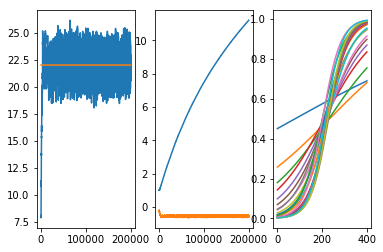

In [10]:
fig2,ax2=plt.subplots(1,3)
ax2[1].plot(W1s)
ax2[1].plot(W2s)
ax2[0].plot(-40*W2s)
ax2[0].plot(22*np.ones((N,)))
ax2[2].plot(Approx2(np.expand_dims(np.arange(400)/10,axis=1),np.expand_dims(W1s[::N//20],axis=0),np.expand_dims(W2s[::N//20],axis=0)))
plt.show()

In [11]:
success2 = np.abs(Approx2(test,W1,W2)-exact(test))<0.4
np.mean(success2)

0.97733599999999998

De convergentie naar onze temperatuur is duidelijk minder, maar de uiteindelijke stapfuncite is wel ietsje steiler.

## Zelfde met Tensorflow

Dit voorbeeld was representatief, en snel met de hand te implementeren. We kijken eens hoe een omgeving als Tensorflow dat proces veranderd. We beginnen -net als eerst- met gradient descent voor dezelfde kwadratische errorfunctie met de A en B variabelen. De convergentie is vergelijkbaar.

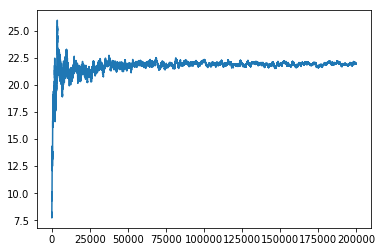

In [12]:
import tensorflow as tf

#recreate the funcitons
A_tf = tf.Variable(tf.ones([1,1]))
B_tf = tf.Variable(tf.ones([1])*(-0.2))
T_tf = tf.placeholder(dtype=tf.float32,shape=[None,1])

Approx_tf = tf.nn.sigmoid(tf.matmul(T_tf,A_tf) + B_tf)
T_approx = - 40 * B_tf / A_tf[0]

#define error and correction method reflected before in dA/dB
Ex_tf = tf.placeholder(dtype=tf.float32,shape=[None,1])
error2 = tf.losses.mean_squared_error(Ex_tf,Approx_tf) 
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(error2)

#let tensorflow do the work
init = tf.global_variables_initializer()
Tas =[]
with tf.Session() as sess:
    sess.run(init)
    for T in Ts:
        Ti=np.array([[T]])
        _, Tapprox = sess.run([optimizer, T_approx], feed_dict={T_tf: nz(Ti),Ex_tf: exact(Ti)})
        Tas +=[Tapprox]

fig,ax =plt.subplots()
ax.plot(Tas)
plt.show()

We kunnen hetzelfde doen met onconventionele 2-layer ansatz, en vinden ook het sterker fluctuerend resultaat van eerst.

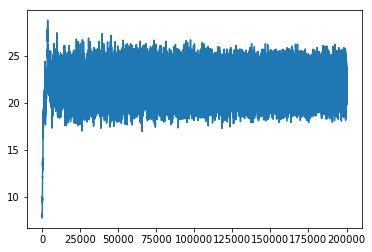

In [13]:
#rename the variables
W1_tf = tf.Variable(tf.ones([1,1]))
W2_tf = tf.Variable(tf.ones([1])*(-0.2))
Approx2_tf = tf.nn.sigmoid(tf.matmul(T_tf+W2_tf,W1_tf))
T_approx2 = - 40 * W2_tf
error22 = tf.losses.mean_squared_error(Ex_tf,Approx2_tf) 
optimizer2 = tf.train.GradientDescentOptimizer(alpha).minimize(error22)

#let tensorflow do the work
init = tf.global_variables_initializer()
Tas2 =[]
with tf.Session() as sess:
    sess.run(init)
    for T in Ts:
        Ti=np.array([[T]])
        _, Tapprox = sess.run([optimizer2, T_approx2], feed_dict={T_tf: nz(Ti),Ex_tf: exact(Ti)})
        Tas2 +=[Tapprox]

fig3,ax3 =plt.subplots()
ax3.plot(Tas2)
plt.show()

## Tensorflow: The next level

Nu we beschikken over alle tensorflow tools kunnen we proberen onze approach te optimizen en wat testen. 

Eerst proberen we andere cost-functie: de cross-entropy die de sigmoid als kansverdeling ziet en de afwijking tov de perfecte orde aangeeft.

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


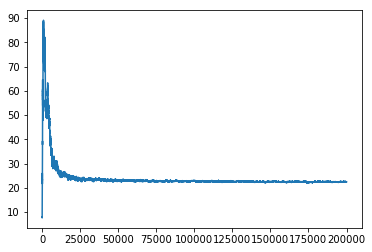

[array([ 22.44886971], dtype=float32), array([ 22.46318817], dtype=float32), array([ 22.46885109], dtype=float32), array([ 22.4802227], dtype=float32), array([ 22.48030853], dtype=float32), array([ 22.48093224], dtype=float32), array([ 22.47340584], dtype=float32), array([ 22.46727562], dtype=float32), array([ 22.46408272], dtype=float32)]


In [14]:
alpha = 0.1
#define error and correction method reflected before in dA/dB
logloss = tf.losses.sigmoid_cross_entropy(Ex_tf,Approx_tf) 
optimizer3 = tf.train.GradientDescentOptimizer(alpha).minimize(logloss)

#let tensorflow do the work
init = tf.global_variables_initializer()
Tas =[]
with tf.Session() as sess:
    sess.run(init)
    for T in Ts:
        Ti=np.array([[T]])
        _, Tapprox = sess.run([optimizer3, T_approx], feed_dict={T_tf: nz(Ti),Ex_tf: exact(Ti)})
        Tas +=[Tapprox]

fig,ax =plt.subplots()
ax.plot(Tas)
plt.show()
print(Tas[-10:-1])

Aanvaardbaar. 

Nu veranderen we de optimizer eens naar [AdaDelta](https://arxiv.org/pdf/1212.5701.pdf). Dit is een Gradient Descent methode met adaptieve learning rate, at minimal computational cost.

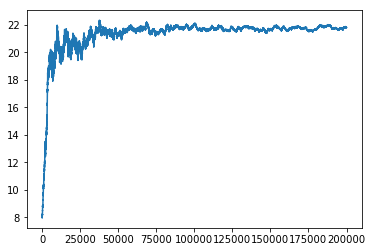

[[ 21.77520752]
 [ 21.7785511 ]
 [ 21.78129005]
 [ 21.78446198]
 [ 21.78540039]
 [ 21.78704643]
 [ 21.78429222]
 [ 21.78166389]
 [ 21.77939987]]


In [15]:
alpha = 0.5
#define error and correction method reflected before in dA/dB
cost= tf.losses.mean_squared_error(Ex_tf,Approx_tf) 
optimizer3 = tf.train.AdadeltaOptimizer(alpha).minimize(cost)

#let tensorflow do the work
init = tf.global_variables_initializer()
Tas =[]
with tf.Session() as sess:
    sess.run(init)
    for T in Ts:
        Ti=np.array([[T]])
        _, Tapprox = sess.run([optimizer3, T_approx], feed_dict={T_tf: nz(Ti),Ex_tf: exact(Ti)})
        Tas +=[Tapprox]

fig,ax =plt.subplots()
ax.plot(Tas)
plt.show()
print(np.array(Tas[-10:-1]))

Not bad. 

Out of interest doen we nog eens een andere: Adam, die soort geoptimaliseerde combinatie is van de vorige 2 optimisers. Die werkt inderdaad beter dan de voorgaande, maar wat als we ook terug de wat mindere costfunctie -de cross-entropy- gebruiken? W maken nog een andere aanpassing: batches. 

In plaats van datapunt per datapunt te evalueren doen we het per 'batch' van een aantal datapunten

In [16]:
Tbatches=Ts.reshape((100,-1))

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


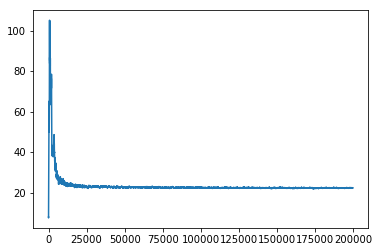

[[ 22.27873802  22.28060341  22.28273773  22.28614616  22.28921509
   22.29199028  22.29380035  22.29496002  22.29584885]]


In [ ]:
alpha = 0.01
#define error and correction method reflected before in dA/dB
cost= tf.losses.sigmoid_cross_entropy(Ex_tf,Approx_tf) 
optimizer3 = tf.train.AdamOptimizer(alpha).minimize(cost)

#let tensorflow do the work
init = tf.global_variables_initializer()
Tas =[]
with tf.Session() as sess:
    sess.run(init)
    for Tbatch in Tbatches:
        #Ti=np.array([[Tbatch]])
        _, Tapprox = sess.run([optimizer3, T_approx], feed_dict={T_tf: nz(Tbatch),Ex_tf: exact(Tbatch)})
        Tas +=[Tapprox]

fig,ax =plt.subplots()
ax.plot(Tas)
plt.show()
print(np.array(Tas[-10:-1]).T)

Convergentie is sneller, maar nog steeds niet heel dicht bij 22.

## Tensorboard in progress

Om ons model te kunnen bekijken loggen we de tensorflow variablen in een summary zodat we ze in een aangepaste view kunnen weergeven. Voorlopig lukt dat niet te goed.

In [ ]:
import numpy as np
import tensorflow as tf
alpha=0.01

N=200000
Ts= np.random.normal(22,4,N)

def nz(T):
    return T / 40

def exact(T):
    return (np.sign(T-22) + 1) / 2

#recreate the funcitons
A_tf = tf.Variable(tf.ones([1,1]))
B_tf = tf.Variable(tf.ones([1])*(-0.2))
T_tf = tf.placeholder(dtype=tf.float32,shape=[None,1])

Approx_tf = tf.nn.sigmoid(tf.matmul(T_tf,A_tf) + B_tf)
T_approx = - 40 * B_tf / A_tf[0]

#add variables to summary
# tf.summary.scalar('A_weight',tf.reduce_mean(A_tf))
# tf.summary.scalar('Bias',tf.reduce_mean(B_tf))
# tf.summary.scalar('T_approximation',tf.reduce_mean(T_approx))
# tf.summary.scalar('somescalar',tf.constant(1.0,tf.float32))


#merged = tf.summary.merge_all()
#writer = tf.summary.FileWriter('C:\\Users\\Jos\\iCloudDrive\\Documents\\Work\\Jupyter\\TBkoen',sess.graph)

#define error and correction method reflected before in dA/dB
Ex_tf = tf.placeholder(dtype=tf.float32,shape=[None,1])
error2 = tf.losses.mean_squared_error(Ex_tf,Approx_tf) 
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(error2)

tf.summary.scalar('error',error2)
merged = tf.summary.merge_all()

#let tensorflow do the work
init = tf.global_variables_initializer()
Tas =[]
with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('C:\\Users\\Jos\\iCloudDrive\\Documents\\Work\\Jupyter\\TBkoen',sess.graph)
    i=0
    for T in Ts:
        merged = tf.summary.merge_all()
        Ti=np.array([[T]])
        summary, _ = sess.run([merged, error2], feed_dict={T_tf: nz(Ti),Ex_tf: exact(Ti)})
        writer.add_summary(summary,i)
        i += i

Lets check it out

cmd "tensorboard --logdir='C:\\Users\\Jos\\iCloudDrive\\Documents\\Work\\Jupyter\\TBkoen'"

browse 'http://Demogorgon:6006'
